In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Goal: predict whether a user will purchase an item using an e-commerce dataset

Loading data: online retail dataset from Kaggle

In [100]:
retail_data = pd.read_csv('data.csv', encoding='ISO-8859-1')
retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [101]:
retail_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


Exploring and cleaning the data:

InvoiceNo are either numeric (completed transaction), or start with C or A (canceled or adjusted transactions)

We will remove canceled and adjusted transactions, keeping only completed transactions

In [102]:
# Number of unique transactions
print(f'Number of unique transactions: {retail_data.InvoiceNo.unique().shape[0]:5d}')

# Transactions with missing InvoiceNo
missing_invoices = retail_data[retail_data['InvoiceNo'].isna()]
print(f"Number of transactions with missing InvoiceNo: {missing_invoices.shape[0]:1d}")

# Canceled or adjusted transactions (non-numeric InvoiceNo ; starting with C or A)
canceled_invoices = retail_data[~retail_data['InvoiceNo'].str.isnumeric()]
print(f"Number of unique canceled or adjusted transactions: {canceled_invoices['InvoiceNo'].unique().shape[0]:5d}")

# Remove canceled or adjusted transactions
cleaned_retail_data = retail_data[retail_data['InvoiceNo'].str.isnumeric()].copy()
cleaned_retail_data['InvoiceNo'] = cleaned_retail_data['InvoiceNo'].astype(int)

Number of unique transactions: 25900
Number of transactions with missing InvoiceNo: 0
Number of unique canceled or adjusted transactions:  3839


Also drop rows with missing CustomerID

In [103]:
# Find rows with missing CustomerID
missing_customerid = cleaned_retail_data[cleaned_retail_data['CustomerID'].isna()]
print(f"Number of transactions with missing CustomerID: {missing_customerid.shape[0]:1d}")

# Drop rows with missing CustomerID
cleaned_retail_data = cleaned_retail_data.dropna(subset=['CustomerID'])
cleaned_retail_data['CustomerID'] = cleaned_retail_data['CustomerID'].astype(int)

Number of transactions with missing CustomerID: 134694


More data cleaning: convert InvoiceDate to datetime format and compute total price

In [104]:
# Convert InvoiceDate to datetime
cleaned_retail_data['InvoiceDate'] = pd.to_datetime(cleaned_retail_data['InvoiceDate'], format='%m/%d/%Y %H:%M')

# Compute TotalPrice
cleaned_retail_data['TotalPrice'] = cleaned_retail_data['Quantity'] * cleaned_retail_data['UnitPrice']

In [105]:
cleaned_retail_data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [106]:
cleaned_retail_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397924 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397924 non-null  int64         
 1   StockCode    397924 non-null  object        
 2   Description  397924 non-null  object        
 3   Quantity     397924 non-null  int64         
 4   InvoiceDate  397924 non-null  datetime64[ns]
 5   UnitPrice    397924 non-null  float64       
 6   CustomerID   397924 non-null  int64         
 7   Country      397924 non-null  object        
 8   TotalPrice   397924 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(3), object(3)
memory usage: 30.4+ MB


Exploratory Data Analysis

In [107]:
# Get number of unique users
num_unique_users = cleaned_retail_data['CustomerID'].nunique()
print(f'Number of unique users: {num_unique_users:5d}')

# Get number of purchases per user
purchases_per_user = cleaned_retail_data.groupby('CustomerID').size()
print(f'Average number of purchases per user: {purchases_per_user.mean():.2f}')
print(f'Median number of purchases per user: {purchases_per_user.median():.2f}')
print(f'Max number of purchases per user: {purchases_per_user.max():.2f}')

# Get number of purchases per item
purchases_per_item = cleaned_retail_data.groupby('StockCode').size()
print(f'Average number of purchases per item: {purchases_per_item.mean():.2f}')
print(f'Median number of purchases per item: {purchases_per_item.median():.2f}')
print(f'Max number of purchases per item: {purchases_per_item.max():.2f}')

Number of unique users:  4339
Average number of purchases per user: 91.71
Median number of purchases per user: 41.00
Max number of purchases per user: 7847.00
Average number of purchases per item: 108.57
Median number of purchases per item: 49.00
Max number of purchases per item: 2035.00


StockCode: 85123A, Description: WHITE HANGING HEART T-LIGHT HOLDER
StockCode: 22423, Description: REGENCY CAKESTAND 3 TIER
StockCode: 85099B, Description: JUMBO BAG RED RETROSPOT
StockCode: 84879, Description: ASSORTED COLOUR BIRD ORNAMENT
StockCode: 47566, Description: PARTY BUNTING
StockCode: 20725, Description: LUNCH BAG RED RETROSPOT
StockCode: 22720, Description: SET OF 3 CAKE TINS PANTRY DESIGN 
StockCode: 20727, Description: LUNCH BAG  BLACK SKULL.
StockCode: POST, Description: POSTAGE
StockCode: 23203, Description: JUMBO BAG DOILEY PATTERNS


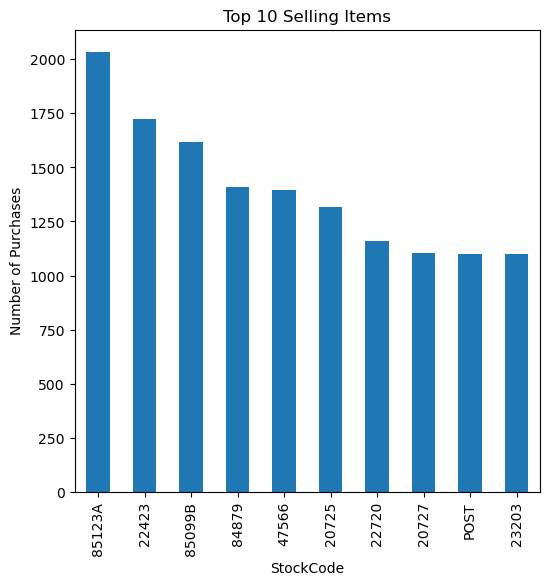

In [112]:
# Visualize top-selling items
top_selling_items = purchases_per_item.sort_values(ascending=False).head(10)
f, ax = plt.subplots(1,1, figsize=(6, 6))
top_selling_items.plot(kind='bar')
ax.set_title('Top 10 Selling Items')
ax.set_xlabel('StockCode')
ax.set_ylabel('Number of Purchases')

# Print corresponding Description for each StockCode
for stock_code in top_selling_items.index:
    description = cleaned_retail_data[cleaned_retail_data['StockCode'] == stock_code]['Description'].iloc[0]
    print(f'StockCode: {stock_code}, Description: {description}')

Text(0, 0.5, 'Number of Purchases')

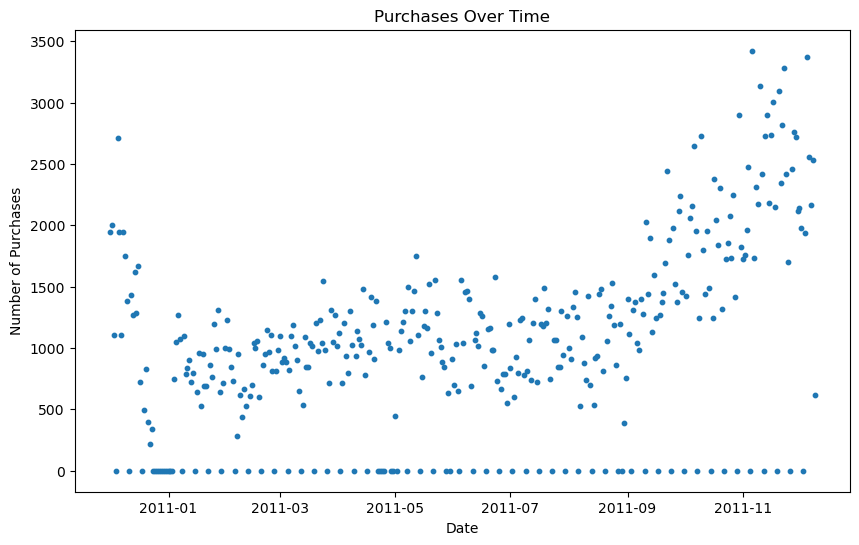

In [114]:
# Visualize purchase trends over time
purchases_over_time = cleaned_retail_data.set_index('InvoiceDate').resample('D').size()
f, ax = plt.subplots(1,1, figsize=(10, 6))
ax.scatter(purchases_over_time.index, purchases_over_time.values, s=10)
ax.set_title('Purchases Over Time')
ax.set_xlabel('Date')
ax.set_ylabel('Number of Purchases')

We notice a spike around November / December + some days with 0 purchases

In [110]:
# Seems like we got a lot of 0 purchases on certain days. Let's investigate
zero_purchase_days = purchases_over_time[purchases_over_time == 0]
print(f'Number of days with zero purchases: {zero_purchase_days.shape[0]:3d}')
print(f'Days with zero purchases: {zero_purchase_days.index}')

Number of days with zero purchases:  69
Days with zero purchases: DatetimeIndex(['2010-12-04', '2010-12-11', '2010-12-18', '2010-12-24',
               '2010-12-25', '2010-12-26', '2010-12-27', '2010-12-28',
               '2010-12-29', '2010-12-30', '2010-12-31', '2011-01-01',
               '2011-01-02', '2011-01-03', '2011-01-08', '2011-01-15',
               '2011-01-22', '2011-01-29', '2011-02-05', '2011-02-12',
               '2011-02-19', '2011-02-26', '2011-03-05', '2011-03-12',
               '2011-03-19', '2011-03-26', '2011-04-02', '2011-04-09',
               '2011-04-16', '2011-04-22', '2011-04-23', '2011-04-24',
               '2011-04-25', '2011-04-29', '2011-04-30', '2011-05-02',
               '2011-05-07', '2011-05-14', '2011-05-21', '2011-05-28',
               '2011-05-30', '2011-06-04', '2011-06-11', '2011-06-18',
               '2011-06-25', '2011-07-02', '2011-07-09', '2011-07-16',
               '2011-07-23', '2011-07-30', '2011-08-06', '2011-08-13',
           

Text(0, 0.5, 'Number of Purchases')

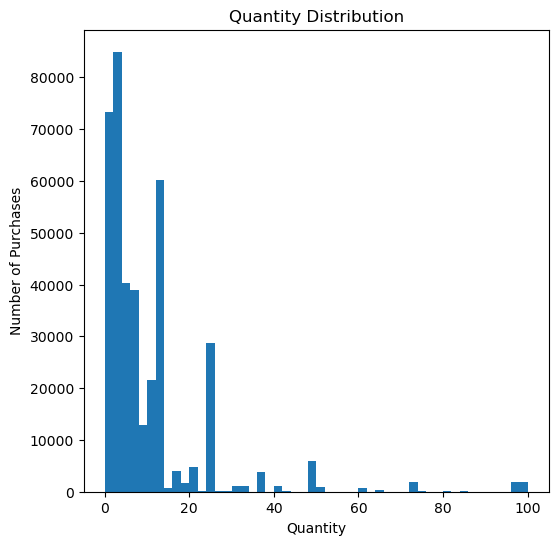

In [118]:
# Look at quantity distributions
f, ax = plt.subplots(1,1, figsize=(6, 6))
ax.hist(cleaned_retail_data['Quantity'], bins=50, range=(0, 100))
ax.set_title('Quantity Distribution')
ax.set_xlabel('Quantity')
ax.set_ylabel('Number of Purchases')

Most customers buy only a few units per transaction, but few transactions involve very large quantities

Look for seasonality or patterns by month/week/day


/var/folders/gn/kmp970g50zgf_030nc9dcr5m0000gn/T/ipykernel_40546/2894834502.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_counts = cleaned_retail_data.resample('M', on='InvoiceDate').size()


Text(0, 0.5, 'Number of Purchases')

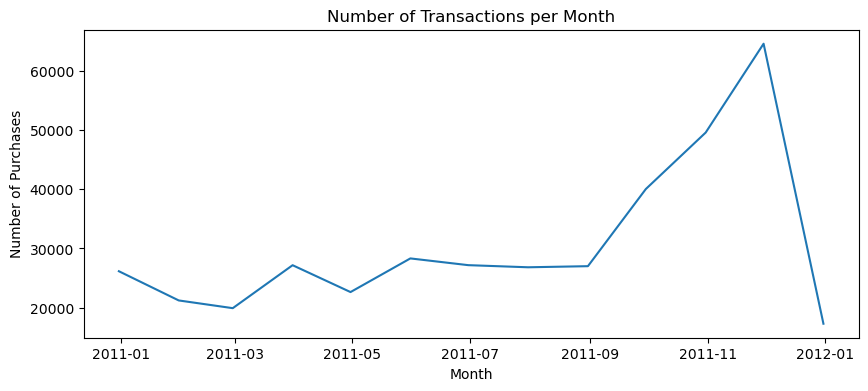

In [ ]:
# Creating time-based features
cleaned_retail_data['Year'] = cleaned_retail_data['InvoiceDate'].dt.year
cleaned_retail_data['Month'] = cleaned_retail_data['InvoiceDate'].dt.month
cleaned_retail_data['Week'] = cleaned_retail_data['InvoiceDate'].dt.isocalendar().week
cleaned_retail_data['DayOfWeek'] = cleaned_retail_data['InvoiceDate'].dt.dayofweek  # Monday=0
cleaned_retail_data['Hour'] = cleaned_retail_data['InvoiceDate'].dt.hour

# Look for monthly seasonality
monthly_counts = cleaned_retail_data.resample('M', on='InvoiceDate').size()
plt.figure(figsize=(10,4))
plt.plot(monthly_counts.index, monthly_counts.values)
plt.title('Number of Transactions per Month')
plt.xlabel('Month')
plt.ylabel('Number of Purchases')

/var/folders/gn/kmp970g50zgf_030nc9dcr5m0000gn/T/ipykernel_40546/355485069.py:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_sales = cleaned_retail_data.resample('M', on='InvoiceDate')['TotalPrice'].sum()


Text(0, 0.5, 'Revenue (£)')

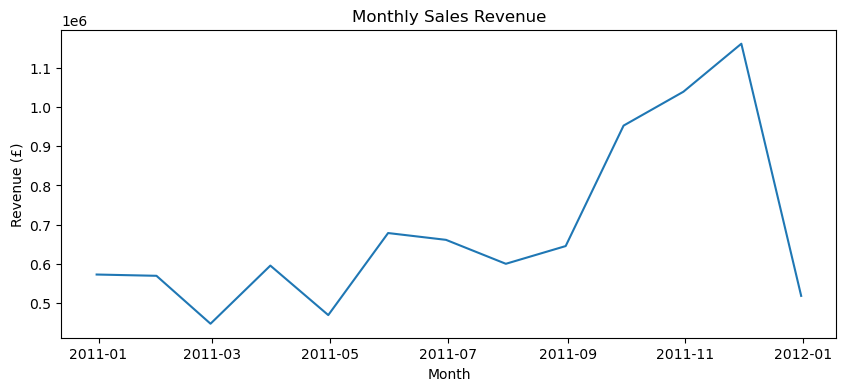

In [124]:
# Look at sales revenue instead
cleaned_retail_data['TotalPrice'] = cleaned_retail_data['Quantity'] * cleaned_retail_data['UnitPrice']

monthly_sales = cleaned_retail_data.resample('M', on='InvoiceDate')['TotalPrice'].sum()

plt.figure(figsize=(10,4))
plt.plot(monthly_sales.index, monthly_sales.values)
plt.title('Monthly Sales Revenue')
plt.xlabel('Month')
plt.ylabel('Revenue (£)')

Clear seasonal pattern: spike around November / December = holiday season

Text(0, 0.5, 'Revenue (£)')

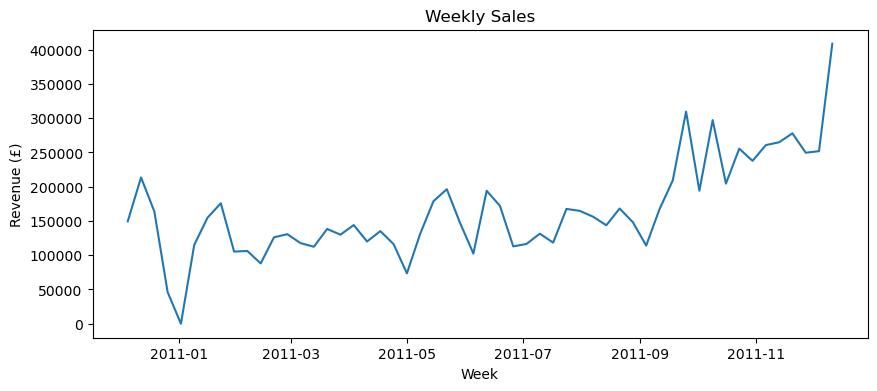

In [127]:
# Look for weekly trends
weekly_sales = cleaned_retail_data.resample('W', on='InvoiceDate')['TotalPrice'].sum()
plt.figure(figsize=(10,4))
plt.plot(weekly_sales.index, weekly_sales.values)
plt.title('Weekly Sales')
plt.xlabel('Week')
plt.ylabel('Revenue (£)')

Text(0, 0.5, 'Revenue (£)')

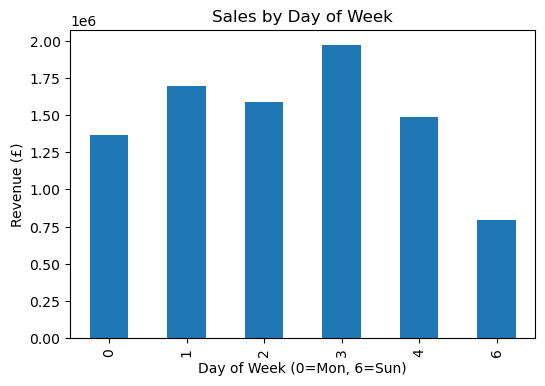

In [129]:
day_of_week_sales = cleaned_retail_data.groupby('DayOfWeek')['TotalPrice'].sum()

plt.figure(figsize=(6,4))
day_of_week_sales.plot(kind='bar')
plt.title('Sales by Day of Week')
plt.xlabel('Day of Week (0=Mon, 6=Sun)')
plt.ylabel('Revenue (£)')